In [1]:
import warnings

warnings.filterwarnings("ignore")

# Learning goals
After today's lesson you should be able to:
- Understand the differences between SLX, spatial lag and spatial error models
- Identify when to use different kinds of models
- Implement all three types of models in pysal
- Check our model outcomes 

This week's lesson is a simplied version of:  
- The [Week 11 on Spatial Regression the Geographic Data Science book](https://geographicdata.science/book/notebooks/11_regression.html)


In [2]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn


## Data: San Diego Airbnb

To learn a little more about how regression works, we'll examine information about Airbnb properties in San Diego, CA. 
This dataset contains house intrinsic characteristics, both continuous (number of beds as in `beds`) and categorical (type of renting or, in Airbnb jargon, property group as in the series of `pg_X` binary variables), but also variables that explicitly refer to the location and spatial configuration of the dataset (e.g., distance to Balboa Park, `d2balboa` or neighborhood id, `neighborhood_cleansed`).

Also, note that there is a great notebook in the Geographic Data Science book on [how this dataset was cleaned](https://geographicdata.science/book/data/airbnb/regression_cleaning.html). It has some example code for: 
- How to calculate the driving distance to a certain location (Balboa Park in this example) using a free API called Nomatim, since we only learned about the Google Maps API. 
- How to get the elevation of a location
- How to categorize neighborhoods (here, by size and whether they are coastal).
- Creating dummy variables


In [3]:
db = geopandas.read_file("https://www.dropbox.com/s/zkucu7jf1xug869/regression_db.geojson?dl=1")
# db['pool'] = db['pool'].astype(int)
# db['coastal'] = db['coastal'].astype(int)
# db['pg_Apartment'] = db['pg_Apartment'].astype(int)
# db['pg_Condominium'] = db['pg_Condominium'].astype(int)
# db['pg_House'] = db['pg_House'].astype(int)
# db['pg_Other'] = db['pg_Other'].astype(int)
# db['pg_Townhouse'] = db['pg_Townhouse'].astype(int)
# db['rt_Entire_home/apt'] = db['rt_Entire_home/apt'].astype(int)
# db['rt_Private_room'] = db['rt_Private_room'].astype(int)
# db['rt_Shared_room'] = db['rt_Shared_room'].astype(int)

Notice here that we have: 
- **Discrete variables** (number of bedrooms, beds, baths)
- **Dummy variables** (whether there is a pool, whether near the coast, room type)

**Remember that for dummy variables we always run the regression leaving out one category as our baseline.**

In [4]:
db.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'neighborhood', 'pool',
       'd2balboa', 'coastal', 'price', 'log_price', 'id', 'pg_Apartment',
       'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse',
       'rt_Entire_home/apt', 'rt_Private_room', 'rt_Shared_room', 'geometry'],
      dtype='object')

In [5]:
db.shape

(6110, 20)

These are the explanatory variables we will use throughout the chapter.

In [6]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

## Non-spatial regression, a (very) quick refresh
For example, in our case, we may want to express the price of a house as a function of the number of bedrooms it has and whether it is a condominium or not. At the individual level, we can express this as:

$$
log(P_i) = \alpha + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

where $P_i$ is the Airbnb price of house $i$, and $X$ is a set of covariates that we use to explain such price (e.g., No. of bedrooms and condominium binary variable). $\beta$ is a vector of parameters that give us information about in which way and to what extent each variable is related to the price, and $\alpha$, the constant term, is the average house price when all the other variables are zero. The term $\epsilon_i$ is usually referred to as "error" and captures elements that influence the price of a house but are not included in $X$.

We also take the log of prices often since a log scale allows us a better understanding of the percentage change instead of the absolute dollar change.  

We can also express this relation in matrix form, excluding sub-indices for $i$, which yields:

$$
log(P) = \alpha + \mathbf{X}\beta + \epsilon
$$

Practically speaking, linear regressions in Python are rather streamlined and easy to work with. There are also several packages which will run them (e.g., `statsmodels`, `scikit-learn`, `pysal`). We will import the `spreg` module in Pysal:

In [7]:
from pysal.model import spreg

In the context of this chapter, it makes sense to start with `spreg`, as that is the only library that will allow us to move into explicitly spatial econometric models. To fit the model specified in the equation above with $X$ as the list defined, using ordinary least squares (OLS), we only need the following line of code:

In [8]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variable_names,
)

We use the command `OLS`, part of the `spreg` sub-package, and specify the dependent variable (the log of the price, so we can interpret results in terms of percentage change) and the explanatory ones. Note that both objects need to be arrays, so we extract them from the `pandas.DataFrame` object using `.values`.

In order to inspect the results of the model, we can print the `summary` attribute:

In [9]:
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:     1320.15                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

------------------------------------------------------------

Results are largely as expected: houses tend to be significantly more expensive if they accommodate more people (`accommodates`), if they have more bathrooms and bedrooms, and if they are a condominium or part of the "other" category of house type. Conversely, given a number of rooms, houses with more beds (i.e., listings that are more "crowded") tend to go for cheaper, as it is the case for properties where one does not rent the entire house but only a room (`rt_Private_room`) or even shares it (`rt_Shared_room`). Of course, you might conceptually doubt the assumption that it is possible to *arbitrarily* change the number of beds within an Airbnb without eventually changing the number of people it accommodates, but methods to address these concerns using *interaction effects* won't be discussed here. 

### Hidden structures

In general, our model performs well, being able to predict slightly about two-thirds ($R^2=0.67$) of the variation in the mean nightly price using the covariates we've discussed above.
But, our model might display some clustering in the errors, which may be a problem as that violates the i.i.d. assumption linear models usually come built-in with. 
To interrogate this, we can do a few things. 
One simple concept might be to look at the correlation between the error in predicting an Airbnb and the error in predicting its nearest neighbor. 
To examine this, we first might want to split our data up by regions and see if we've got some spatial structure in our residuals. 
One reasonable theory might be that our model does not include any information about *beaches*, a critical aspect of why people live and vacation in San Diego. 
Therefore, we might want to see whether or not our errors are higher or lower depending on whether or not an Airbnb is in a "beach" neighborhood, a neighborhood near the ocean. We use the code below to generate Figure XXX1XXX, which looks at prices between the two groups of houses, "beach" and "no beach".

Note here that `m1.u` are the residuals from the model `m1`. 

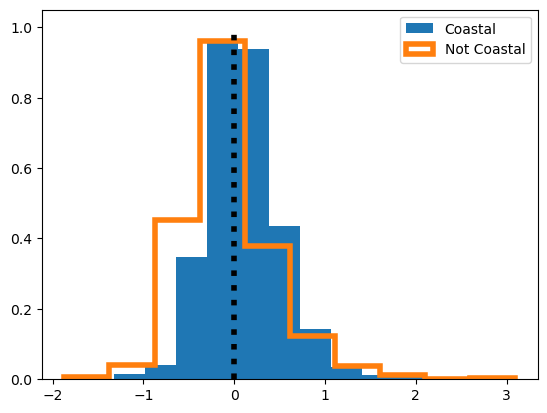

In [10]:
# Create a Boolean (True/False) with whether a
# property is coastal or not
is_coastal = db.coastal.astype(bool)
# Split residuals (m1.u) between coastal and not
coastal = m1.u[is_coastal]
not_coastal = m1.u[~is_coastal]
# Create histogram of the distribution of coastal residuals
plt.hist(coastal, density=True, label="Coastal")
# Create histogram of the distribution of non-coastal residuals
plt.hist(
    not_coastal,
    histtype="step",
    density=True,
    linewidth=4,
    label="Not Coastal",
)
# Add Line on 0
plt.vlines(0, 0, 1, linestyle=":", color="k", linewidth=4)
# Add legend
plt.legend()
# Display
plt.show()

While it appears that the neighborhoods on the coast have only slightly higher average errors (and have lower variance in their prediction errors), the two distributions are significantly distinct from one another when compared using a classic $t$-test:

In [11]:
from scipy.stats import ttest_ind
ttest_ind(coastal, not_coastal)

TtestResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]), df=array([6108.]))

## Q1 
What does the pvalue above tell us about how the errors in our data on the coast compared to neighborhoods not on the coast? Why are errors on the coast higher?

The pvalue tells us that our observation is not statistically insignificant, there seems to be a large difference in the means. The errors on the coast is higher because we are consistently under-predicting their prices (which is expected, as our model does not distinguish between the coast versus not).

Additionally, it might be the case that some neighborhoods are more desirable than other neighborhoods due to unmodeled latent preferences or marketing. 
For instance, despite its presence close to the sea, living near Camp Pendleton -a Marine base in the North of the city- may incur some significant penalties on area desirability due to noise and pollution. These are questions that domain knowledge provides and data analysis can help us answer.
For us to determine whether this is the case, we might be interested in the full distribution of model residuals within each neighborhood. 

To make this more clear, we'll first sort the data by the median residual in that neighborhood, and then make a boxplot (Fig. XXX2XXX), which shows the distribution of residuals in each neighborhood:

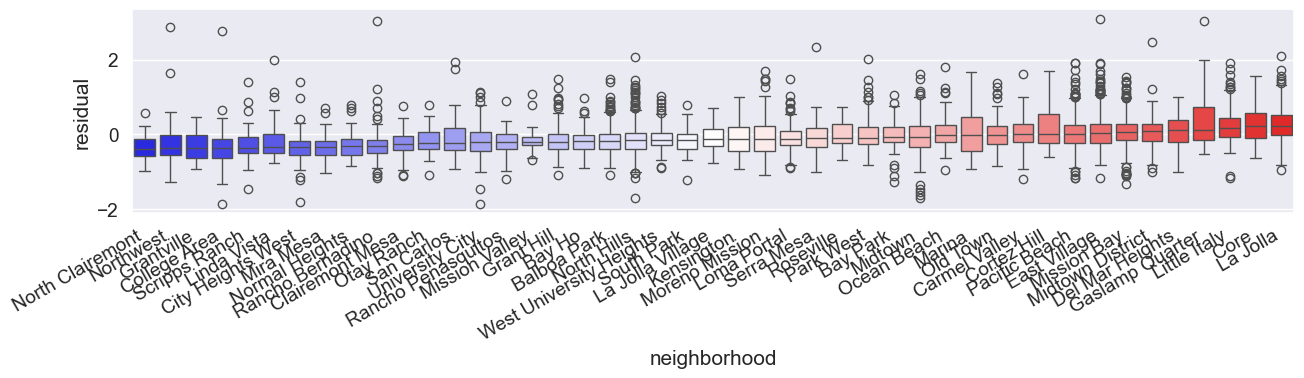

In [12]:
# Create column with residual values from m1
db["residual"] = m1.u
# Obtain the median value of residuals in each neighborhood
medians = (
    db.groupby("neighborhood")
    .residual.median()
    .to_frame("hood_residual")
)

# Increase fontsize
seaborn.set(font_scale=1.25)
# Set up figure
f = plt.figure(figsize=(15, 3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighborhood
# Note the data includes the median values merged on-the-fly
seaborn.boxplot(
    data=db.merge(
        medians, how="left", left_on="neighborhood", right_index=True
    ).sort_values("hood_residual"),
    x="neighborhood",
    y="residual",
    ax=ax,
    palette="bwr",
)
# Auto-format of the X labels
f.autofmt_xdate()
# Display
plt.show()

No neighborhood is disjoint from one another, but some do appear to be higher than others, such as the well-known downtown tourist neighborhoods areas of the Gaslamp Quarter, Little Italy, or The Core. 
Thus, there may be a distinctive effect of intangible neighborhood fashionableness that matters in this model. 

Noting that many of the most over- and under-predicted neighborhoods are near one another in the city, it may also be the case that there is some sort of *contagion* or spatial spillovers in the nightly rent price. 
This often is apparent when individuals seek to price their Airbnb listings to compete with similar nearby listings. 
Since our model is not aware of this behavior, its errors may tend to cluster. 
**One exceptionally simple way we can look into this structure is by examining the relationship between an observation's residuals and its surrounding residuals.**

To do this, we will use *spatial weights* to represent the geographic relationships between observations. 
We cover spatial weights in detail in [Chapter 4](04_spatial_weights), so we will not repeat ourselves here.
For this example, we'll start off with a $KNN$ matrix where $k=1$, meaning we're focusing only on the linkages of each Airbnb to their closest other listing.

In [13]:
knn = weights.KNN.from_dataframe(db, k=1)

This means that, when we compute the *spatial lag* of that $KNN$ weight and the residual, we get the residual of the Airbnb listing closest to each observation.

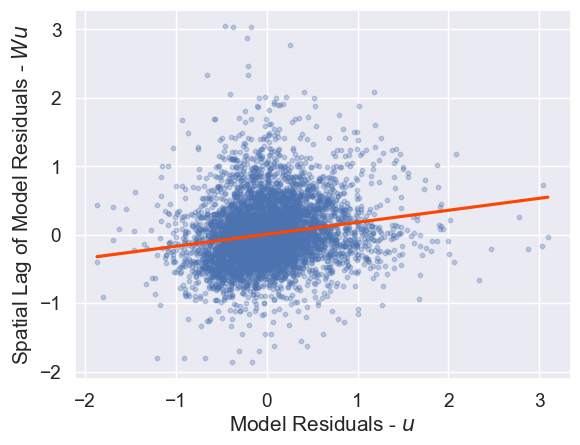

In [14]:
## Here lag_spatial is a function that returns the spatial lag of a variable
## given a certain set of weights

lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    x=m1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    scatter_kws={'alpha': 0.3,'s':10},
    ci=None,
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $W u$");

In Figure XXX3XXX, we see that our prediction errors tend to cluster!
Above, we show the relationship between our prediction error at each site and the prediction error at the site nearest to it. 
Here, we're using this nearest site to stand in for the *surroundings* of that Airbnb. 
This means that, when the model tends to over-predict a given Airbnb's nightly log price, sites around that Airbnb are more likely to *also be over-predicted*. 

Let's look at the stable $k=20$ number of neighbors.
Examining the relationship between this stable *surrounding* average and the focal Airbnb, we can even find clusters in our model error. 
Recalling the *local Moran* statistics in [Chapter 7](07_local_autocorrelation), Figure XXX4XXX is generated from the code below to identify certain areas where our predictions of the nightly (log) Airbnb price tend to be significantly off:

In [15]:
# Re-weight W to 20 nearest neighbors
knn20 = weights.KNN.from_dataframe(db, k=20)# Row standardize weights

knn20.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn20, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns

db = db.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    ).query(
        "error_clusters"
        # Sort by I value to largest plot on top
    ).sort_values(
        "local_I"
        # Plot I values
    )
 
db.explore('local_I')

Thus, these areas tend to be locations where our model significantly under-predicts the nightly Airbnb price both for that specific observation and observations in its immediate surroundings. 
This is critical since, if we can identify how these areas are structured &mdash; if they have a *consistent geography* that we can model &mdash; then we might make our predictions even better, or at least not systematically mis-predict prices in some areas while correctly predicting prices in other areas. Since significant under- and over-predictions do appear to cluster in a highly structured way, we might be able to use a better model to fix the geography of our model errors. 


### Spatial feature engineering: proximity variables
One relevant proximity-driven variable that could influence our San Diego model is based on the listings proximity to Balboa Park. A common tourist destination, Balboa Park is a central recreation hub for the city of San Diego, containing many museums and the San Diego Zoo. Thus, it could be the case that people searching for Airbnbs in San Diego are willing to pay a premium to live closer to the park. If this were true *and* we omitted this from our model, we may indeed see a significant spatial pattern caused by this distance decay effect. 

Therefore, this is sometimes called a *spatially patterned omitted covariate*: geographic information our model needs to make good predictions which we have left out of our model. Therefore, let's build a new model containing this distance to Balboa Park covariate. First, though, it helps to visualize (Fig. XXX5XXX) the structure of this distance covariate itself:

In [16]:
db.explore('d2balboa')

To run a linear model that includes the additional variable of distance to the park, we add the name to the list of variables we included originally:

In [17]:
balboa_names = variable_names + ["d2balboa"]

And then fit the model using the OLS class in Pysal's `spreg`:

In [18]:
m2 = spreg.OLS(
    db[["log_price"]].values,
    db[balboa_names].values,
    name_y="log_price",
    name_x=balboa_names,
)

In [19]:
print(m2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:         487
Mean dependent var  :      4.7799                Number of Variables   :          12
S.D. dependent var  :      1.0187                Degrees of Freedom    :         475
R-squared           :      0.7416
Adjusted R-squared  :      0.7356
Sum squared residual:     130.334                F-statistic           :    123.9156
Sigma-square        :       0.274                Prob(F-statistic)     :  6.939e-132
S.E. of regression  :       0.524                Log likelihood        :    -370.050
Sigma-square ML     :       0.268                Akaike info criterion :     764.099
S.E of regression ML:      0.5173                Schwarz criterion     :     814.358

------------------------------------------------------------

When you inspect the regression diagnostics and output, you see that this covariate is not quite as helpful as we might anticipate:

In [20]:
pandas.DataFrame(
    [[m1.r2, m1.ar2], [m2.r2, m2.ar2]],
    index=["M1", "M2"],
    columns=["R2", "Adj. R2"],
)

,R2,Adj. R2
M1,0.668345,0.667801
M2,0.741577,0.735592


And, there still appears to be spatial structure in our model's errors, as we can see in Figure XXX6XXX, generated by the code below:

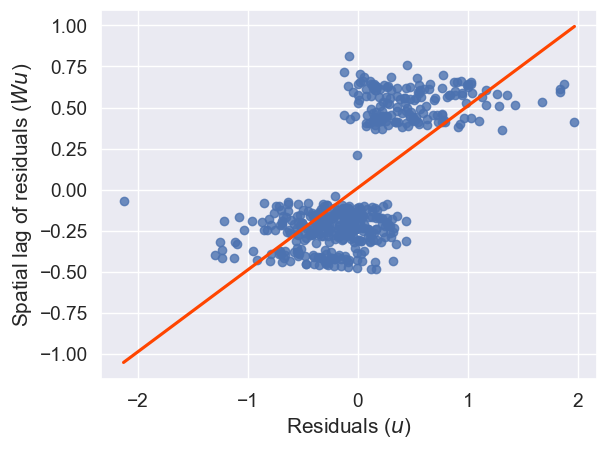

In [21]:
knn20 = weights.KNN.from_dataframe(db, k=20)# Row standardize weights
knn20.transform = "R"

lag_residual = weights.spatial_lag.lag_spatial(knn20, m2.u)
ax = seaborn.regplot(
    x=m2.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

Finally, the distance to Balboa Park variable does not fit our theory about how distance to amenity should affect the price of an Airbnb; the coefficient estimate is *positive*, meaning that people are paying a premium to be *further* from Balboa Park. We will revisit this result later on, when we consider spatial heterogeneity and will be able to shed some light on this. Further, the next chapter is an extensive treatment of spatial fixed effects, presenting many more spatial feature engineering methods. Here, we have only showed how to include these engineered features in a standard linear modeling framework. 

## Q.2
Run another model (m3), where we think distance to the airport might be an important factor in determining prices. What might be the relationship between distance to airport and price? 

I think airbnbs very near the airport will have higher prices, but once after a certain distance, prices might not be affected. Or, prices might even increase farther away from the airport if the airbnbs are located near urban centers.

Now add a new column `d2airport` that has the distance between each Airbnb location and the airport 32.732346 (lattitude) -117.196053(longitude). 

In [25]:
import pandas as pd
import geopandas as gpd

In [28]:
#distance is in meters

a_point_xy = pd.DataFrame({'longitude': [-117.196053], 'latitude':[32.732346] })
a_point = gpd.GeoDataFrame(a_point_xy, geometry=gpd.points_from_xy(a_point_xy.longitude, a_point_xy.latitude), crs='EPSG:4326')


db['d2airport'] = db.to_crs(3857).distance(a_point.to_crs(3857).iloc[0].geometry)

Now run and print the summary results of a model that includes the `variable_names` list, `d2balboa`, and `d2airport`. 

In [29]:
## INSERT YOUR CODE HERE
airport_balboa_names = variable_names + ["d2balboa"] + ['d2airport']

m3 = spreg.OLS(
    db[["log_price"]].values,
    db[airport_balboa_names].values,
    name_y="log_price",
    name_x=airport_balboa_names,
)

In [30]:
print(m3.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:         487
Mean dependent var  :      4.7799                Number of Variables   :          13
S.D. dependent var  :      1.0187                Degrees of Freedom    :         474
R-squared           :      0.7896
Adjusted R-squared  :      0.7843
Sum squared residual:      106.11                F-statistic           :    148.2447
Sigma-square        :       0.224                Prob(F-statistic)     :  7.401e-152
S.E. of regression  :       0.473                Log likelihood        :    -319.980
Sigma-square ML     :       0.218                Akaike info criterion :     665.960
S.E of regression ML:      0.4668                Schwarz criterion     :     720.407

------------------------------------------------------------

Were you able to confirm your hypothesis? Why or why not? What might be the issue with including both `d2balboa`, and `d2airport` in your model? (Hint: look at the two locations on a map.)

In [31]:
a_point.explore()

I was not able to confirm my hypothesis, as there seems to be a very small correlation between the price and distance to airport. Looking at the airport location, I realized that it is very close to Balboa Park. Including both d2balboa and d2airport violates the model assumption of independent variables.